### Introduction
This notebook demonstrates how to use **FOS** to train a MNIST model. The input for this model are scans of handwritten digits (0-9) and the target is the digit that it represents. There is only one digit per image and all images have the same shape. The dataset required to train MNIST is part of `Torchvision` and will be downloaded the first time you run this notebook.


In [12]:
# Uncomment the following line if running on Google Colab
# !pip install fos

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

# Import the Fos classes we are going to use in this notebook
from fos import Workout
from fos.callbacks import NotebookMeter
from fos.metrics import SingleClassAccuracy, plot_metrics

### Define Data & Model

The first part of the script is setting up the data loaders and the model architecture. There are no specific FOS classes required here. FOS will work just fine with regular PyTorch classes like the `DataLoader` and the `nn.Module`. The model isself is a small network with 2 Convolutional layers and 2 Linear layers. Since it has so few layers and parameters, it wil run fine on most modern CPU's.

In [13]:
def get_dataloaders():
    '''Loads the images required to train the model. First time will download them from the Internet.'''
    
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    
    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=128, shuffle=True)
    
    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=128, shuffle=False)
    
    return train_loader, val_loader


class DigitPredictor(nn.Module):
    '''A simple convolutional network for predicting the digits'''

    def __init__(self, n_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(1, 5, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU(),
                        nn.Conv2d(5, 10, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU())
        
        self.fc = nn.Sequential(
                        nn.Linear(160, 32),
                        nn.ReLU(),
                        nn.Linear(32, n_classes))

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

    

### Setup

We now get to the part where we instantiate everything.  If you have a GPU, you can change the code below that instantiates the predictor to `DigitPredictor().to("cuda")` in order to speedup the training. However since this is a small model it will also perform fine on most modern CPU's.

`Workout` is the Fos class that combines a model, loss, optimizer and metrics and is at the center of most of the functionality offered by Fos. If you don't specify an optimizer, SGD will be used. You can also define as many metrics as you like. Here we just use one metric, namely single class accury.


In [14]:
model   = DigitPredictor()
workout = Workout(model, F.nll_loss, acc=SingleClassAccuracy())

data_train, data_valid = get_dataloaders()

### The training

Remains running the training for a number of epochs. In order to also display the status and metrics, we use the NotebookMeter. It is one of the available callbacks that can be used during training. Besides callbacks that display or log information, there are also callbacks that for example stop the training if there is no more progress.

When we run the training, we supply both the data for training and validation phases and specify for how many epochs we want to run this training. If the validation data is not provided, the validation phase is skipped all together. And if no value for the number of epochs is provided, 1 epoch is assumed.

Since the workout keeps track of the state, you can rerun the cell multiple times and it just continues where it left off (the epoch and step counters don't reset). This allows for a iterative development approach in for example a Jupyter notebook. So just rerun the cell below multiple times if you whish.

In [15]:
workout.fit(data_train, data_valid, epochs=10, callbacks=[NotebookMeter()])

[  1:   469] - loss: 2.2603 - acc: 0.1667 - val_loss: 2.2481 - val_acc: 0.1434: 100%|██████████|00:14<00:00
[  2:   938] - loss: 2.1998 - acc: 0.2083 - val_loss: 2.1545 - val_acc: 0.2691: 100%|██████████|00:14<00:00
[  3:  1407] - loss: 1.8594 - acc: 0.5833 - val_loss: 1.8924 - val_acc: 0.4921: 100%|██████████|00:15<00:00
[  4:  1876] - loss: 1.3574 - acc: 0.6771 - val_loss: 1.1921 - val_acc: 0.7428: 100%|██████████|00:16<00:00
[  5:  2345] - loss: 0.7532 - acc: 0.8438 - val_loss: 0.6484 - val_acc: 0.8381: 100%|██████████|00:16<00:00
[  6:  2814] - loss: 0.6517 - acc: 0.8438 - val_loss: 0.4602 - val_acc: 0.8732: 100%|██████████|00:16<00:00
[  7:  3283] - loss: 0.4127 - acc: 0.8750 - val_loss: 0.3721 - val_acc: 0.9021: 100%|██████████|00:15<00:00
[  8:  3752] - loss: 0.4717 - acc: 0.8542 - val_loss: 0.3238 - val_acc: 0.9097: 100%|██████████|00:15<00:00
[  9:  4221] - loss: 0.3560 - acc: 0.8854 - val_loss: 0.2966 - val_acc: 0.9239: 100%|██████████|00:17<00:00
[ 10:  4690] - loss: 0.5096 

## Visualization
The workout captured the metrics and can now be used analyse the metrics. In this case we plot some graphs. We use the `plot_metrics` convenience method to do this, but by using `workout.history[metricname]` the metrics can be used for other purposes.

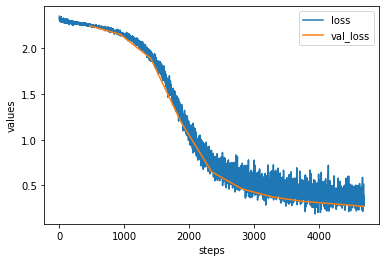

In [16]:
from matplotlib import pyplot as plt
plot_metrics(plt, workout, ["loss", "val_loss"])

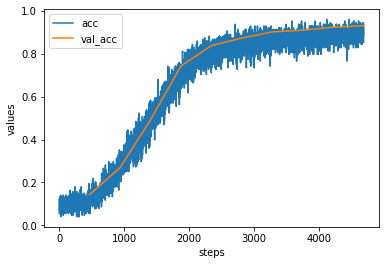

In [17]:
plot_metrics(plt, workout, ["acc", "val_acc"])

## Save and restore training sessions

If you want to save the training state, use the `workout.save()` method. You can optionally specify a filename or let a directory and filename be generated for you. The workout will save the following state:

1. Its own state, like which step and epoch it is at.
2. History of the logged metrics.
3. Model state, so the learned parameters. 
4. Optimizer state, like for example the momentum of parameters.


In [18]:
workout.save("my_best_model.pty")

'my_best_model.pty'

And if at later stage you want to continue where you left off or perhaps revert back to a previously saved version, just restore the state from one of the files with `workout.load()`.

In [19]:
workout.load("my_best_model.pty")

'my_best_model.pty'